<a href="https://colab.research.google.com/github/namra98/Deep-Learning/blob/master/Data_Science_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook was created for IEEE MI-SIG Data Science Challenge.
## Given person's name, description, followers and following, we have to identify whether person is real Doctor or not.

## Main Steps are as Follows:
**1. Analysis**
*   number of positive and negative examples.
*   I had question whather there is direct relation of output with number of followers. Plot of number of followers for pos and neg. Both were nearly same.
*   Occurence of drugs and diseases words in description, Maybe real doctors used it more?. That was also not the case, actully fakers used these word more often. No direct relationship. 

**2. Data Pre-Processing for every text field:**
*    Replaced Nan values to "None" keyword.
*    make all words lowercase
*    remove stop words
*    tokenize words of a sentance into array
*    build vocabulary of all words
*    Used **GloVe** word embeddings for all words in vocabulary
*    padding to make leangth of all sentence length equal (column wise not global)
*    I was stuck here for some times, how to use 4 vectors of embeddings to get most meaningful representation, just concatinated them(couldent find batter approch).

**3. Model 1**
*   I ommitted followers in first model.
*   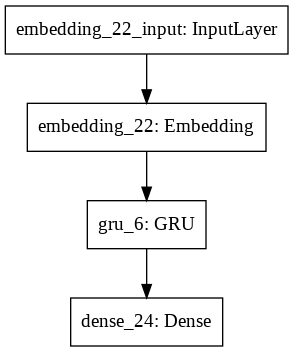

**4. Model 2**
*   Included followers in second model but didnt saw any significant diffrence.
*    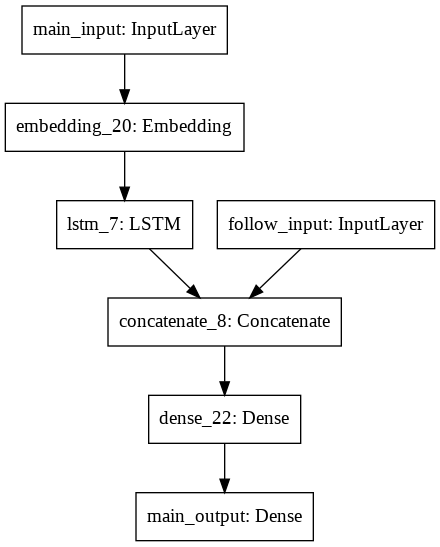

**Model 3**
*   LSTM insted of GRU.

This is very basic and crude model. If you find something can be improved, please do ping me.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout, GRU, Input
from keras import optimizers
import keras
from keras.utils import plot_model
from sklearn.metrics import accuracy_score
from keras.optimizers import SGD
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
import string

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

from sklearn.model_selection import train_test_split

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
train_path = '/content/drive/My Drive/dataset/train.csv'
test_path = '/content/drive/My Drive/dataset/testComplete.csv'
drugsList = '/content/drive/My Drive/dataset/drugsList.txt'
diseaseList = '/content/drive/My Drive/dataset/diseaseList.txt'

In [0]:
drugs = []
with open(drugsList) as f:
  drugs = f.read().split('\n')
  drugs = drugs[1:]

disease = []
with open(diseaseList) as f:
  disease = f.read().split('\n')
  disease = disease[1:]

In [0]:
df = pd.read_csv(train_path)
df.head()
X = df.drop('HCP_flag', axis=1)
y = df['HCP_flag']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
X_train.head()

,UID,Handle,Name,Description,Location,Followers_count,Following_count
2072,13669,zeddthenel,nelson,NaN,NaN,21,58
6052,2072,uscpa,Ken Aizawa,やられたらやり返す！倍返し！ 夢は叶えるものなんだ、世界一週したいです、でもその前にUSCP...,Tokyo,333,259
5751,14357,soty06,Diego Sotillo,"Estudiante, ex-baloncestista y cinefilo medio!",Ourense,134,351
5654,10523,perth_meso_dr,Anna Nowak,Dr Anna Nowak is a researcher and medical onco...,"Perth, Australia",127,55
1788,1875,eemmppbb,Elia Ma. Perera B.,Elia Ma. Perera B.,México,27,72


In [0]:
X_test.shape

(2214, 7)

1716 4993


<BarContainer object of 2 artists>

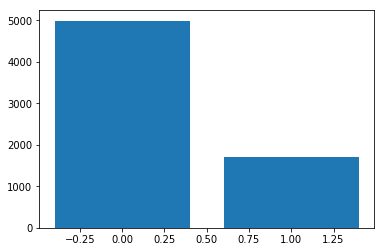

In [0]:
n_pos = y.values.sum()
n_neg = len(y.values) - n_pos
print(n_pos, n_neg)

plt.bar([0,1], [n_neg, n_pos])

In [0]:
df_pos = df[df['HCP_flag'] == 1]
df_neg = df[df['HCP_flag'] == 0]

df_pos.head()

,UID,Handle,Name,Description,Location,Followers_count,Following_count,HCP_flag
0,4778,oncoblogbulbul,Oncoblog,Oncólogo médico. Músico. Lector empedernido. P...,NaN,1133,592,1
5,10929,stephrstarr,Stephanie Starr MD,General pediatrician & medical educator (UME h...,"Rochester, Minnesota",96,159,1
7,875,karenychin,Karen,NaN,NaN,57,83,1
19,5581,digneurosurgeon,Pieter Kubben,"Neurosurgeon, PhD on intraoperative MRI, devel...","Maastricht, The Netherlands",2515,211,1
34,4818,erlbacher72,LE,"Pharmacist, Certified Financial Planner, Fathe...",NaN,65,68,1


In [0]:
nan_values = {'Description':'None', 'Location':'None'}
df = df.fillna(value=nan_values)
df_pos = df_pos.fillna(value=nan_values)
df_neg = df_neg.fillna(value=nan_values)
X_train = X_train.fillna(value=nan_values)
X_test = X_test.fillna(value=nan_values)
df_pos.head()

,UID,Handle,Name,Description,Location,Followers_count,Following_count,HCP_flag
0,4778,oncoblogbulbul,Oncoblog,Oncólogo médico. Músico. Lector empedernido. P...,None,1133,592,1
5,10929,stephrstarr,Stephanie Starr MD,General pediatrician & medical educator (UME h...,"Rochester, Minnesota",96,159,1
7,875,karenychin,Karen,None,None,57,83,1
19,5581,digneurosurgeon,Pieter Kubben,"Neurosurgeon, PhD on intraoperative MRI, devel...","Maastricht, The Netherlands",2515,211,1
34,4818,erlbacher72,LE,"Pharmacist, Certified Financial Planner, Fathe...",None,65,68,1


<BarContainer object of 2 artists>

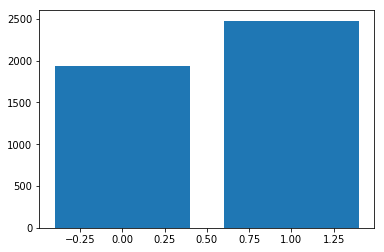

In [0]:
df_neg['Followers_count'].mean()
plt.bar([0,1], [df_neg['Followers_count'].mean(), df_pos['Followers_count'].mean()])

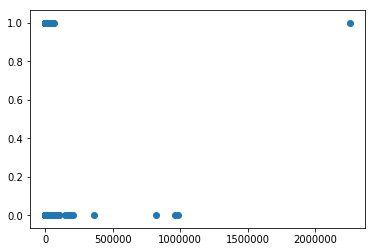

In [0]:
plt.scatter(df['Followers_count'].values, df['HCP_flag'].values)

In [0]:
desc_neg = df_neg['Description'].values
desc_pos = df_pos['Description'].values

In [0]:
drug_cnt_pos = 0
for drug in drugs:
  for desc in desc_pos:
    if drug in desc:
      drug_cnt_pos += 1
      # print(desc)

drug_cnt_neg = 0
for drug in drugs:
  for desc in desc_neg:
    if drug in desc:
      drug_cnt_neg += 1
      # print(desc)

disease_cnt_pos = 0
for dis in disease:
  for desc in desc_pos:
    if dis in desc:
      disease_cnt_pos += 1
      # print(desc)

disease_cnt_neg = 0
for drug in disease:
  for dis in desc_neg:
    if dis in desc:
      disease_cnt_neg += 1               

5040 1741


<BarContainer object of 2 artists>

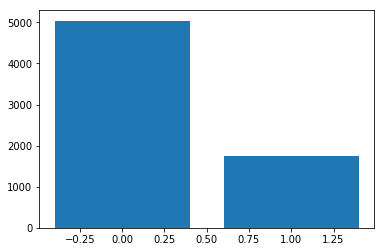

In [0]:
print(drug_cnt_neg, drug_cnt_pos)
plt.bar([0, 1], [drug_cnt_neg, drug_cnt_pos])

8910 2048


<BarContainer object of 2 artists>

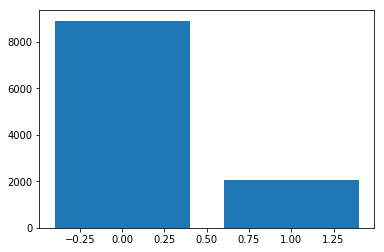

In [0]:
print(disease_cnt_neg, disease_cnt_pos)
plt.bar([0, 1], [disease_cnt_neg, disease_cnt_pos])

In [0]:
max_desc_len = max([len(str(i)) for i in df['Description'].values])
print(max_desc_len)

160


In [0]:
stop = stopwords.words('english') + list(string.punctuation)

In [0]:
X_train['Location'].shape

(4495,)

In [0]:
all_loc = []
for desc in X_train['Location'].values:
  all_loc.append([i for i in word_tokenize(str(desc).lower()) if i not in stop])

all_handle = []
for desc in X_train['Handle'].values:
  all_handle.append([i for i in word_tokenize(str(desc).lower()) if i not in stop])

all_name = []
for desc in X_train['Name'].values:
  all_name.append([i for i in word_tokenize(str(desc).lower()) if i not in stop])

all_desc = []
for desc in X_train['Description'].values:
  all_desc.append([i for i in word_tokenize(str(desc).lower()) if i not in stop])


In [0]:
vocab = []
for desc in all_desc:
  for word in desc:
    vocab.append(word)

for locs in all_loc:
  for word in locs:
    vocab.append(word)

for locs in all_name:
  for word in locs:
    vocab.append(word)

for locs in all_handle:
  for word in locs:
    vocab.append(word)        

vocabulary_size = len(vocab)
print(vocabulary_size)

62331


In [0]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-10-12 17:20:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-10-12 17:20:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-10-12 17:20:03--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove

In [0]:
embeddings_index = dict()
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [0]:
tokenizer = Tokenizer()
embedding_matrix = np.zeros((vocabulary_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector


In [0]:
max_len_loc = 0
for l in all_loc:
  max_len_loc = max(len(str(l)), max_len_loc)

max_len_name = 0
for l in all_name:
  max_len_name = max(len(str(l)), max_len_name)

max_len_handle = 0
for l in all_handle:
  max_len_handle = max(len(str(l)), max_len_handle)

max_len_desc = 0
for l in all_desc:
  max_len_desc = max(len(str(l)), max_len_desc)      

In [0]:
tokenizer.fit_on_texts(all_loc)
tokenizer.fit_on_texts(all_handle)
tokenizer.fit_on_texts(all_desc)
tokenizer.fit_on_texts(all_name)

loc_seq = tokenizer.texts_to_sequences(all_loc)
han_seq = tokenizer.texts_to_sequences(all_handle)
des_seq = tokenizer.texts_to_sequences(all_desc)
nam_seq = tokenizer.texts_to_sequences(all_name)

padded_locs = pad_sequences(loc_seq, maxlen=max_len_loc, padding='post')
padded_hans = pad_sequences(han_seq, maxlen=max_len_handle, padding='post')
padded_desc = pad_sequences(des_seq, maxlen=max_len_desc, padding='post')
padded_names = pad_sequences(nam_seq, maxlen=max_len_name, padding='post')


In [0]:
len(a)

4495

In [0]:
a = padded_locs
a = np.concatenate((a, padded_hans, padded_desc, padded_names), axis=1)
favs = np.vstack((X_train['Followers_count'].values, X_train['Following_count'].values)).T
print(a.shape, favs.shape)

(4495, 359) (4495, 2)


#Model 1

In [0]:
model = Sequential()
e = Embedding(vocabulary_size, 300, weights=[embedding_matrix], input_length=359, trainable=False)
model.add(e)
model.add(GRU(units=64, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(a, y_train, epochs=2)

In [0]:
plot_model(model, to_file='model1.png')

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
loss, accuracy = model.evaluate(a, y_train)
print(accuracy)

## Model 2

In [0]:
main_input = Input(shape=(359,), dtype='int32', name='main_input')
follower_input = Input(shape=(2,), name='follow_input')

x = Embedding(output_dim=300, input_dim=vocabulary_size, input_length=359)(main_input)
lstm_out = LSTM(32)(x)

x = keras.layers.concatenate([lstm_out, follower_input])
x = Dense(64, activation='relu')(x)
main_output = Dense(1, activation='sigmoid', name='main_output')(x)
model2 = Model(inputs=[main_input, follower_input], outputs=main_output)


model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist2 = model2.fit([a, favs], y_train, epochs=2)

# plot_model(model2, to_file='model2.png')

#Model 3

In [0]:
model3 = Sequential()
e = Embedding(vocabulary_size, 300, weights=[embedding_matrix], input_length=359, trainable=False)
model3.add(e)
model3.add(LSTM(units=64, dropout=0.2))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model3.fit(a, y_train, epochs=2)

Epoch 1/2
4495/4495 [==============================] - 65s 14ms/step - loss: 0.5786 - acc: 0.7497
Epoch 2/2
4495/4495 [==============================] - 58s 13ms/step - loss: 0.5651 - acc: 0.7497


#Prediction of X_test

In [0]:
all_loc = []
for desc in X_test['Location'].values:
  all_loc.append([i for i in word_tokenize(str(desc).lower()) if i not in stop])

all_handle = []
for desc in X_test['Handle'].values:
  all_handle.append([i for i in word_tokenize(str(desc).lower()) if i not in stop])

all_name = []
for desc in X_test['Name'].values:
  all_name.append([i for i in word_tokenize(str(desc).lower()) if i not in stop])

all_desc = []
for desc in X_test['Description'].values:
  all_desc.append([i for i in word_tokenize(str(desc).lower()) if i not in stop])


tokenizer.fit_on_texts(all_loc)
tokenizer.fit_on_texts(all_handle)
tokenizer.fit_on_texts(all_desc)
tokenizer.fit_on_texts(all_name)

loc_seq = tokenizer.texts_to_sequences(all_loc)
han_seq = tokenizer.texts_to_sequences(all_handle)
des_seq = tokenizer.texts_to_sequences(all_desc)
nam_seq = tokenizer.texts_to_sequences(all_name)

padded_locs = pad_sequences(loc_seq, maxlen=max_len_loc, padding='post')
padded_hans = pad_sequences(han_seq, maxlen=max_len_handle, padding='post')
padded_desc = pad_sequences(des_seq, maxlen=max_len_desc, padding='post')
padded_names = pad_sequences(nam_seq, maxlen=max_len_name, padding='post')

a2 = padded_locs
a2 = np.concatenate((a2, padded_hans, padded_desc, padded_names), axis=1)
favs = np.vstack((X_test['Followers_count'].values, X_test['Following_count'].values)).T

In [0]:
loss, acc = model.evaluate(a2, y_test)
print("Model 1 Accuracy : ", acc)

loss, acc = model2.evaluate([a2, favs], y_test)
print("Model 2 Accuracy : ", acc)

loss, acc = model3.evaluate(a2, y_test)
print("Model 3 Accuracy : ", acc)

2214/2214 [==============================] - 6s 3ms/step
Model 1 Accuracy :  0.7330623306233063
2214/2214 [==============================] - 6s 3ms/step
Model 2 Accuracy :  0.6779584462511292
2214/2214 [==============================] - 8s 4ms/step
Model 3 Accuracy :  0.7330623306233063
